Setting up environment

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Importing necessary libraries
import tensorflow as tf # tensorflow 2.x
from tensorflow.keras import models, layers
from tensorflow.keras import backend as K
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Activation, Dropout, Lambda, Conv2DTranspose, AveragePooling2D, GaussianNoise
from keras.models import Model
from keras import backend as K
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from sklearn.utils import class_weight
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.utils.class_weight import compute_class_weight
from tensorflow import keras
from tensorflow.keras.layers import Layer
from tensorflow.keras import mixed_precision
from tensorflow.keras.optimizers import Adam
from keras.losses import mean_squared_error
from tensorflow.keras.layers import ZeroPadding2D, Add, Cropping2D, BatchNormalization
from keras.losses import mean_squared_error
from matplotlib import pyplot as plt
import matplotlib
import time
import numpy as np
from scipy import stats
from keras import metrics
import random
import math
import pandas as pd
import statistics
from scipy.signal.windows import gaussian

from tensorflow.keras.layers import Concatenate
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.utils import to_categorical

!pip install hic-straw
import hicstraw

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.13.1-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.1-py3-none-any.whl (238 kB)
  Created wheel for hic-straw: filename=hic_straw-1.3.1-cp310-cp310-linux_x86_64.whl size=1616846 sha256=5c21b8526558c0ae9dba71bbda22be5475e306101f91febec096467f80a3ee94
  Stored in directory: /root/.cache/pip/wheels/23/85/e0/14f1be833ddf1da34165e04938653e00b602eb93e834497ae4
Successfully built hic-straw


In [ ]:
WIDTH=40 # Size of input matrix
res=50000 # resolution
br = matplotlib.colors.LinearSegmentedColormap.from_list("bright_red",[(1,1,1),(1,0,0)]) # color scheme
np.set_printoptions(suppress = True)
folder = "/content/drive/MyDrive/Chirag/Data/Distance Model Training Data (50 KB)/"
bins = ['0_to_0.25MB', '0.25_to_0.5MB', '0.5_to_1MB', '1_to_2MB', '2_to_5MB',
        '5_to_10MB', '10_to_20MB', '20+MB', 'Interchromosomal'] # Types of data

In [ ]:
# Loading training files

!wget https://www.dropbox.com/s/jqbb36osbzy121r/HIC11665_PPM_HiRise_rh_HiC.hic
!wget https://www.dropbox.com/s/p1l512m2lx1zkcf/HIC12835_PPM_HiRise_rh_HiC.hic
!wget https://www.dropbox.com/s/pxa547b3dsdd8qv/Daubentonia_madagascariensis_HiC.hic
!wget https://www.dropbox.com/s/1uq0ijiiuj39wbn/Chrysocyon_brachyurus_HiC.hic
!wget https://www.dropbox.com/s/otgsb1624ohru7s/Setonix_brachyurus_HiC.hic
#!wget https://www.dropbox.com/sh/3eh3lbzedwc0hrg/AADEdyqNcKklsw9ihtdxds0Ja/HIC16040_canFam3.hic
!wget https://www.dropbox.com/s/igegfumda9jrlxy/primary.hic

files = ['HIC11665_PPM_HiRise_rh_HiC.hic',
         'HIC12835_PPM_HiRise_rh_HiC.hic',
         'Daubentonia_madagascariensis_HiC.hic',
         'Chrysocyon_brachyurus_HiC.hic',
         'Setonix_brachyurus_HiC.hic',
        #'HIC16040_canFam3.hic',
         'primary.hic']

# Loading testing files

!wget https://www.dropbox.com/sh/3eh3lbzedwc0hrg/AABHmvN7KxvYvaQgbNwKceFha/HIC1024_deep.hic
testing_files = ['HIC1024_deep.hic']

--2024-08-08 23:11:16--  https://www.dropbox.com/s/jqbb36osbzy121r/HIC11665_PPM_HiRise_rh_HiC.hic
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/jqbb36osbzy121r/HIC11665_PPM_HiRise_rh_HiC.hic [following]
--2024-08-08 23:11:16--  https://www.dropbox.com/s/raw/jqbb36osbzy121r/HIC11665_PPM_HiRise_rh_HiC.hic
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc68c9bc67fd8924fbc867836fb7.dl.dropboxusercontent.com/cd/0/inline/CYRui8ctgd8ByS6tn_z9C0NTehRrkdYpQXIr12ZUSj8yRJ_3ewKu3_vxZW8uQ2Rq31Xthl2Fj3Ss-Bs_jGMp6O63M4fIZprFs3WL5h2OsiSOxKEGOSyzFUjlcQdmaHS-3xES78i0EfNe-rcU5qO780bY/file# [following]
--2024-08-08 23:11:17--  https://uc68c9bc67fd8924fbc867836fb7.dl.dropboxusercontent.com/cd/0/inline/CYRui8ctgd8ByS6tn_z9C0NTehRrkdYpQXIr12ZUSj8yRJ_3

Preprocessing functions

In [ ]:
# OE functions

# Averages out each diagonal
# For symmetric matrices, return an array with the values on each diagonal replaced by the average of that diagonal
def replace_diagonal_with_average(arr):
  max_offset = arr.shape[0]
  for i in range(1, max_offset):
    np.fill_diagonal(arr[:i, max_offset-i:], np.mean(np.diagonal(arr, offset=max_offset-i)))
    np.fill_diagonal(arr[max_offset-i:, :i], np.mean(np.diagonal(arr, offset=i-max_offset)))
  np.fill_diagonal(arr, np.mean(np.diagonal(arr)))

  return arr

# Return a WIDTH * WIDTH array of a near-diagonal expected matrix

def get_expected_matrix(hic, res, WIDTH, sample_size = 20, data_type = 'observed', normalization = 'NONE', unit = 'BP'):
  expected_matrix = np.zeros([WIDTH, WIDTH])
  expected_matrices = np.zeros([sample_size, WIDTH, WIDTH])
  chroms = hic.getChromosomes()
  num_chroms = len(chroms)-1
  for i in range(sample_size): # Sample of matrices taken
    scaffold = int(random.random()*num_chroms)+1 # Choosing random chromosome
    chr1_start = int(random.random()*(chroms[scaffold].length//res-(WIDTH-1))) * res # Choosing random start point
    matrix = hic.getMatrixZoomData(chroms[scaffold].name, chroms[scaffold].name, data_type, normalization, unit, res)
    matrix = matrix.getRecordsAsMatrix(chr1_start, chr1_start+(WIDTH-1)*res, chr1_start, chr1_start+(WIDTH-1)*res)
    expected_matrices[i, :, :] = replace_diagonal_with_average(matrix) # Creating expected matrix


  for i in range(WIDTH):
    for j in range(WIDTH):
      expected_matrix[i, j] = np.median(expected_matrices[:, i, j]) # Taking median of expected matrices to prevent skew from abnormal examples

  return expected_matrix

In [ ]:
# Centile Rescaling

# Capping the matrix at a certain threshold and then linearly scaling between 0 and 1

def globalPercentileProcess(matrix, threshold):
  return np.where(matrix<threshold, matrix, threshold)/threshold

# Determine numerical value for centile
# Done very similarly to get_expected_matrix function above

def get_med_threshold(hic, centiles, res, WIDTH, sample_size = 20, data_type = 'observed', normalization = 'NONE', unit = 'BP'):
  thresholds=np.zeros([len(centiles), sample_size])
  chroms = hic.getChromosomes()
  num_chroms = len(chroms)-1

  for i in range(sample_size):
    chrom = int(random.random()*num_chroms)+1
    chr1_start = int(random.random()*(chroms[chrom].length//res-(WIDTH-1)))
    matrix = hic.getMatrixZoomData(chroms[chrom].name, chroms[chrom].name, data_type, normalization, unit, res)
    matrix = matrix.getRecordsAsMatrix(chr1_start, chr1_start+(WIDTH-1)*res, chr1_start, chr1_start+(WIDTH-1)*res)

    for idx, centile in enumerate(centiles):
      thresholds[idx, i] = np.percentile(matrix, centile) # Centile threshold calculated for each matrix

  final_thresholds = list()
  for i in range(len(centiles)):
    final_thresholds.append(statistics.median(thresholds[i]))

  return final_thresholds

In [ ]:
# Centiles results modifications
# Populating the middle square of the matrix with 0s

def clearSquare(arr):
  size = arr.shape[1]
  li = size//2 - size//4
  ui = size//2 + size//4
  arr[:, li:ui, li:ui, :] = 0
  return arr

# Populating the sub, sub-sub, super, super-super, and regular diagonal with 0s

def clear_diagonal(array):
  WIDTH = array.shape[1]
  diagonal_indices = np.arange(WIDTH)

  array[:, diagonal_indices, diagonal_indices, :] = 0
  array[:, diagonal_indices[1:], diagonal_indices[:-1], :] = 0
  array[:, diagonal_indices[:-1], diagonal_indices[1:], :] = 0
  array[:, diagonal_indices[2:], diagonal_indices[:-2], :] = 0
  array[:, diagonal_indices[:-2], diagonal_indices[2:], :] = 0
  return array

# Returns just the upper triangular matrix

def clearBelowDiagonal(matrix):
  observed = matrix[:, :, 0]
  modified = np.copy(matrix)
  modified[:, :, 0] = np.triu(observed)
  return modified

# OE normalization options
preprocess = lambda x: np.tanh(np.log(x))
preprocess = lambda x: np.log(x+1)
preprocess = lambda x: np.tanh(x)

In [ ]:
# Performing Gaussian blurring on an image

def gaussian_kernel(kernel_size, std):
    gk1d = gaussian(kernel_size, std).reshape(kernel_size, 1)
    gk2d = np.outer(gk1d, gk1d)
    return gk2d/gk2d.sum()

kernel_size = 5
std_dev = 1.0
gauss_kernel = gaussian_kernel(kernel_size, std_dev)

def blur(image_matrix, gauss_kernel = gauss_kernel, kernel_size = kernel_size):
  image_tensor = tf.reshape(image_matrix, [1, *image_matrix.shape, 1])
  gauss_kernel_tensor = tf.convert_to_tensor(gauss_kernel, dtype=image_tensor.dtype)
  gauss_kernel_tensor = tf.reshape(gauss_kernel_tensor, [kernel_size, kernel_size, 1, 1])
  blurred_image = tf.nn.conv2d(image_tensor, gauss_kernel_tensor, strides=[1, 1, 1, 1], padding="SAME")
  return blurred_image.numpy().squeeze()

Creating traing, validation, and testing data

In [ ]:
# Load and normalize data to create a dataset

class DataLoader:

  def __init__(self, files, folder, bins, res, WIDTH, modify_input = [], centiles = [], centiles_results_modified = [], oe_preprocess = []):

    self.files = files # Storing file names

    hic = []
    for i in self.files:
      hic.append(hicstraw.HiCFile(i)) # Loading hic files

    self.hic = hic
    self.folder = folder # Folder with data
    self.bins = bins # Bin names
    self.res = res # Resolution
    self.WIDTH = WIDTH # Matrix size
    self.modify_input = modify_input # Function to modify input before any preprocessing
    self.centiles = centiles # Centiles to preprocess input data
    self.crm = centiles_results_modified # More preprocess methods to add to the centile processed data
    # e.g if a function to keep only the upper triangular matrix were put here, the data would consist of 1. centile processed data and
    # 2. the upper triangular matrix of the centile precessed data
    self.oep = oe_preprocess # preprocess methods on oe matrices

  def load_data(self):
    all_data = []
    for f in self.files:
      file_data = []
      for bin in bins:
        arr = np.load(folder+f+"/"+bin+".npy") # Loading files
        file_data.append(arr) # Storing the data from each file in a single list

      all_data.append(file_data) # Storing the data from all files in one big list

    self.all_data = all_data # This data will be modified with the preprocessing
    self.original_data = np.copy(all_data) # Original data that will not be modified

    return self

  def modify_input_data(self): # Modifying original data before primary preprocessing methods
    if self.modify_input:
      for file in range(len(self.files)):
        for bin in range(len(self.bins)):
          for idx, arr in enumerate(self.all_data[file][bin]):
            self.all_data[file][bin][idx] = self.modify_input[0](self.WIDTH, arr) # Perform the modification on each training example
    return self

  def processCentiles(self): # Centile preprocessing
    centiles_data_individual = []
    for idx, f in enumerate(self.files):
      hic = self.hic[idx]
      thresholds = get_med_threshold(hic, self.centiles, self.res, self.WIDTH) # Get centile thresholds
      data = self.all_data[idx]
      file_data = []
      for arr in data:
        centile_processed = np.zeros([arr.shape[0], self.WIDTH, self.WIDTH, len(self.centiles)])
        for i in range(len(thresholds)):
          centile_processed[:, :, :, i] = globalPercentileProcess(arr[:, :, :, 0], thresholds[i]) # Perform preprocessing
        file_data.append(centile_processed)
      centiles_data_individual.append(file_data)

    centiles_data = []
    for i in range(len(self.bins)):
      bin = [row[i] for row in centiles_data_individual]
      centiles_data.append(np.concatenate(bin, axis=0)) # Combining the same type of data from different files.


    self.centiles_data = centiles_data

    return self

  def processCentilesResultsModified(self): # More preprocessing methods on top of centile processed data
    centiles_data_modified = []
    for arr in self.centiles_data:
      modified_data = np.zeros([arr.shape[0], self.WIDTH, self.WIDTH, len(self.centiles)*len(self.crm)])
      for idx in range(len(self.crm)):
        # Applying preprocessing methods on top of centile processed data
        modified_data[:, :, :, len(self.centiles)*idx:len(self.centiles)*(idx+1)] = self.crm[idx](np.copy(arr))
      centiles_data_modified.append(modified_data)

    self.centiles_data_modified = centiles_data_modified

    return self

  def processOE(self): # Preprocess methods on oe data

    oe_data_individual = []
    for idx, f in enumerate(self.files):
      hic = self.hic[idx]
      expected_matrix = get_expected_matrix(hic, self.res, self.WIDTH) # Getting expected matrix
      data = self.all_data[idx]
      file_data = []
      for arr in data:
        oe_processed = np.zeros([arr.shape[0], self.WIDTH, self.WIDTH, len(self.oep)])
        for i in range(len(self.oep)):
          # Grabbing oe matrices and applying preprocessing methods
          temp = np.nan_to_num(np.divide(np.copy(arr[:, :, :, 0]), expected_matrix), nan=0.0)
          oe_processed[:, :, :, i] = self.oep[i](temp)
          # Replace the above 2 lines with the line below if you want to use the Juicebox values for observed/expected rather than calculating manually
          # oe_processed[:, :, :, i] = self.oep[i](np.copy(arr[:, :, :, 1]))

        file_data.append(oe_processed)
      oe_data_individual.append(file_data)

    oe_data = []
    for i in range(len(self.bins)):
      bin = [row[i] for row in oe_data_individual]
      oe_data.append(np.concatenate(bin, axis=0))

    self.oe_data = oe_data

    return self

  def combineData(self): # Combining all data
    combined_data = []
    for idx in range(len(self.centiles_data)):
      # Combining the different preprocessed results
      combined_data.append(np.concatenate([self.centiles_data[idx], self.centiles_data_modified[idx], self.oe_data[idx]], axis=-1))

    self.combined_data = combined_data

    return self

  def createLabels(self): # Creating labels
    labels = []
    for i in range(len(self.combined_data)):
      for j in range(self.combined_data[i].shape[0]):
        labels.append(i) # Appending the index of the class the example belongs to

    self.labels = labels

    return self

  def createDataset(self):
    self.data = np.concatenate(self.combined_data) # Combining all data to 1 final big matrix
    self.labels = to_categorical(self.labels, len(self.bins)) # Converting the labels from a number to an array

    return self

  def run(self): # Running all the functions to generate the dataset
    self.load_data()
    self.modify_input_data()
    self.processCentiles()
    self.processCentilesResultsModified()
    self.processOE()
    self.combineData()
    self.createLabels()
    self.createDataset()

In [ ]:
training = DataLoader(files = files[:4], folder = folder, bins = bins, res = res, WIDTH = WIDTH, modify_input = [], centiles = [95, 90, 80], centiles_results_modified = [clear_diagonal, blur], oe_preprocess = [])
training.run() # Creating training data
training_data, training_labels = shuffle(training.data, training.labels)

In [ ]:
validation = DataLoader(files = files[4:], folder = folder, bins = bins, res = res, WIDTH = WIDTH, modify_input = [], centiles = [95, 90, 80], centiles_results_modified = [clear_diagonal, blur], oe_preprocess = [])
validation.run() # Creating validation data
validation_data, validation_labels = shuffle(validation.data, validation.labels)

In [ ]:
testing = DataLoader(files = testing_files, folder = folder, bins = bins, res = res, WIDTH = WIDTH, modify_input = [], centiles = [95, 90, 80], centiles_results_modified = [clear_diagonal, blur], oe_preprocess = [])
testing.run() # Creating testing data
testing_data, testing_labels = testing.data, testing.labels

Text(0.5, 0.98, 'Training data visualization')

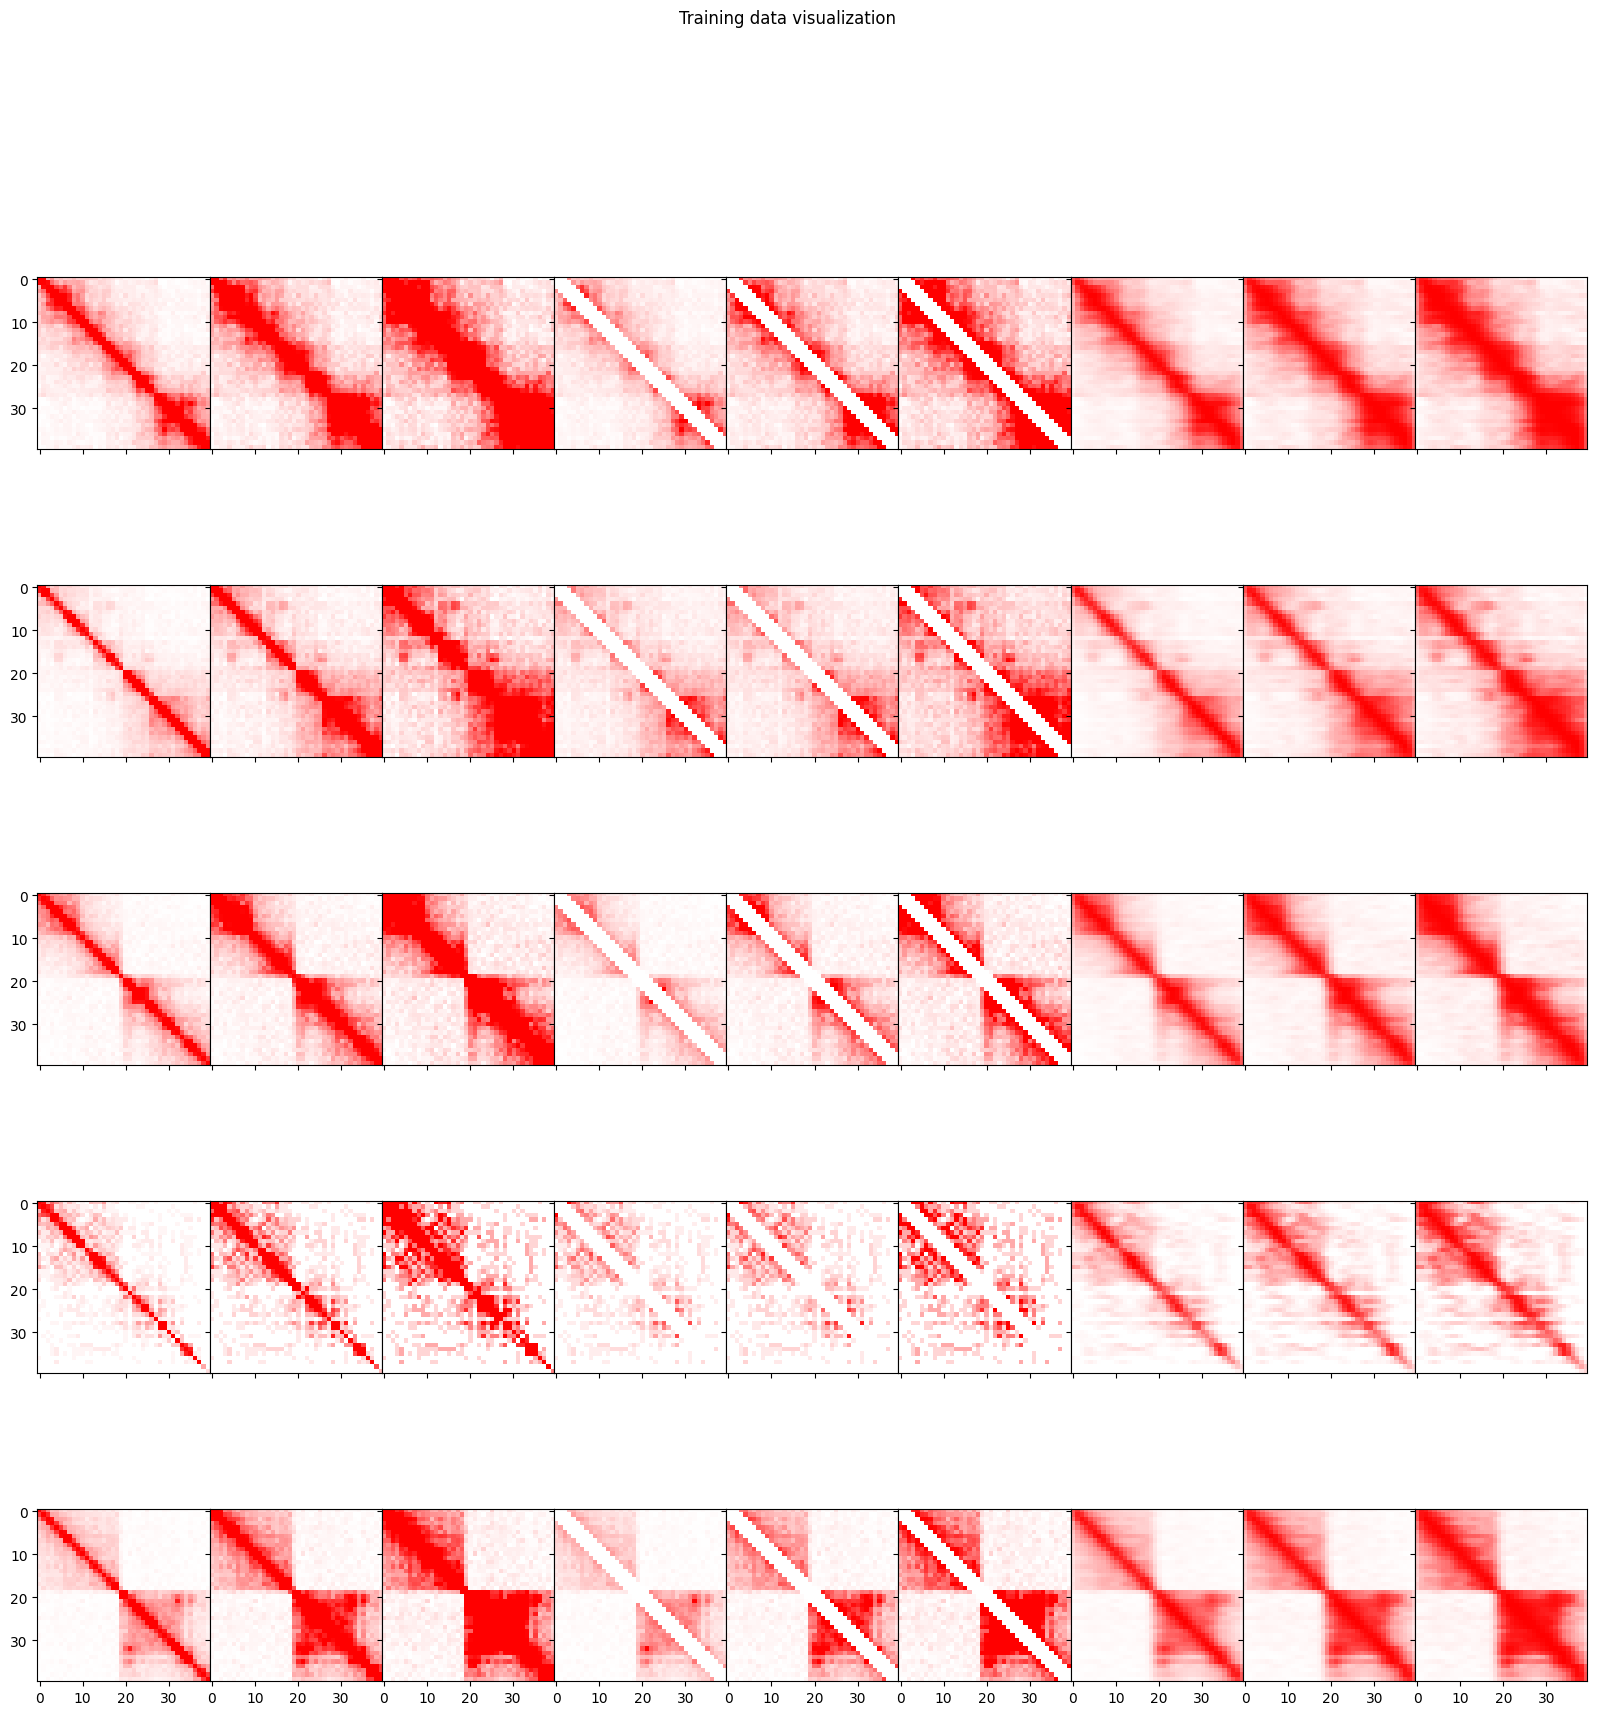

In [ ]:
# Visualizing training examples
num_examples = 5
fig, axs = plt.subplots(num_examples, training_data.shape[-1],figsize=(20, 20), sharex=True, sharey=True,
                        gridspec_kw={'hspace': 0, 'wspace': 0})

exmpls = random.sample(range(training_data.shape[0]), 5) # Choosing random examples from the training data

for i in range(num_examples):
  for j in range(training_data.shape[-1]):
    axs[i, j].imshow(training_data[exmpls[i], :, :, j], cmap=br) # Plotting training data

fig.suptitle("Training data visualization")

Building and training model

In [ ]:
training_ints = np.argmax(training_labels, axis=1)
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(training_ints),
                                        y = training_ints
                                    )

print(class_weights)

input_img = Input(shape=(WIDTH, WIDTH, training_data.shape[-1]))
x = Conv2D(64, (10, 10), activation='relu', padding='same')(input_img)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Flatten()(x)
x = Dropout(0.2)(x)
# Add dropout layer and train more
x = Dense(100, activation= 'relu', kernel_regularizer=l2(0.01))(x) #, kernel_regularizer=l2(0.01), l1
# x = Dense(100, activation= 'relu')(x)
x = Dropout(0.2)(x)
x = Dense(len(training.bins), activation= 'softmax', kernel_regularizer=l2(0.01))(x) #sigmoid, relu
od = Model(input_img, x)

od.summary()
tf.keras.utils.plot_model(od, show_shapes=True, show_layer_activations=True)

## Variable learning rate and early stopping

early_stopping_cb=tf.keras.callbacks.EarlyStopping(monitor= "loss", patience=3,restore_best_weights=True)

od.compile(optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy"])
tf.keras.utils.plot_model(od, show_shapes=True, show_layer_activations=True)

class_weights = dict(zip(np.unique(training_ints), class_weights))

model_hist = od.fit(
                    training_data, training_labels, epochs=10,
                    callbacks=[early_stopping_cb],
                    validation_data=(validation_data, validation_labels),
                    class_weight=class_weights,
                    verbose=1)

[1. 1. 1. 1. 1. 1. 1. 1. 1.]


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 40, 40, 9)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_88 (Conv2D)                   │ (None, 40, 40, 64)          │          57,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_89 (Conv2D)                   │ (None, 40, 40, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 102400)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 102400)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 100)                 │      10,240,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │             909 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,335,601 (39.43 MB)

 Trainable params: 10,335,601 (39.43 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.2076 - loss: 2.9348 - val_accuracy: 0.3472 - val_loss: 1.9567
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.3791 - loss: 1.6676 - val_accuracy: 0.3433 - val_loss: 1.9717
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.3994 - loss: 1.5473 - val_accuracy: 0.3356 - val_loss: 1.9602
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.4230 - loss: 1.4739 - val_accuracy: 0.3478 - val_loss: 1.8240
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.4090 - loss: 1.4547 - val_accuracy: 0.2917 - val_loss: 2.2439
Epoch 6/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.4238 - loss: 1.4254 - val_accuracy: 0.3811 - val_loss: 1.9266
Epoch 7/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4350 - loss: 1.4178 - val_accuracy: 0.3650 - val_loss: 2.0079
Epoch 8/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4422 - loss: 1.3563 - val_accu

Evaluating model

In [ ]:
class Evaluation:

  def __init__(self, model, testing_data, testing_labels, bins):
    self.model = model
    self.testing_data = testing_data
    self.testing_labels = testing_labels
    self.testing_labels_max = testing_labels.argmax(axis=1) # Converting the array label to a single number
    self.counts = np.bincount(self.testing_labels_max) # Count of how many examples of each class there are
    self.WIDTH = testing_data.shape[1]
    self.pm = testing_data.shape[-1] # Number of matrices in each training example (e.g. if there are just 3 centiles then self.pm = 3)
    self.bins = bins # Name of each class

  def predict(self):
    self.preds = self.model.predict(self.testing_data) # predictions
    self.preds_max = self.preds.argmax(axis=1) # determining the most likely class from the prediction
    return self

  def evaluate(self):
    self.loss, self.accuracy = self.model.evaluate(self.testing_data, self.testing_labels)
    return self

  def get_confusion_matrix(self, file_name = None): # Creating confusion matrix
    self.cm = pd.DataFrame(confusion_matrix(self.testing_labels_max, self.preds_max))
    plt.xticks(range(len(self.bins)), self.bins, rotation=45)
    plt.yticks(range(len(self.bins)), self.bins)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.imshow(self.cm)

    plt.colorbar()

    if file_name: # Saving image if file_name specified
      plt.title(file_name)
      plt.savefig(file_name, bbox_inches = 'tight')

    return self

  def get_percents_of_actual_matrix(self): # Building confusion matrix with percents instead of raw numbers
    self.pam = self.cm.copy()
    for idx in range(len(self.pam)):
      self.pam.iloc[idx] = self.pam.iloc[idx]/self.counts[idx]*100

    plt.xticks(range(len(self.bins)), self.bins, rotation=45)
    plt.yticks(range(len(self.bins)), self.bins)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.imshow(self.pam)
    plt.colorbar()

  def visualize_examples(self, predicted, actual, max_examples=10): # To visualize examples where you can specify the actual class and what the model predicted
    examples = []
    for i in range(len(self.preds)): # Getting indexes of examples that meet the criteria
      if predicted == self.preds_max[i]:
        if actual == self.testing_labels_max[i]:
          examples.append(i)

    num_visualize = min(len(examples), max_examples)
    if num_visualize == 0: # In case there are no such examples
      print("There are no examples with predicted, actual =", str(predicted) +  ",", str(actual))
      return

    fig, axs = plt.subplots(num_visualize, self.pm, figsize = (self.WIDTH, self.WIDTH)) # Visualizing the examples
    for i in range(num_visualize):
      for j in range(self.pm):
        axs[i, j].imshow(self.testing_data[examples[i], :, :, j],cmap=br)

    plt.show()

In [ ]:
evaluator = Evaluation(od, testing_data, testing_labels, bins)
evaluator.predict()
evaluator.evaluate()

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3646 - loss: 1.7050


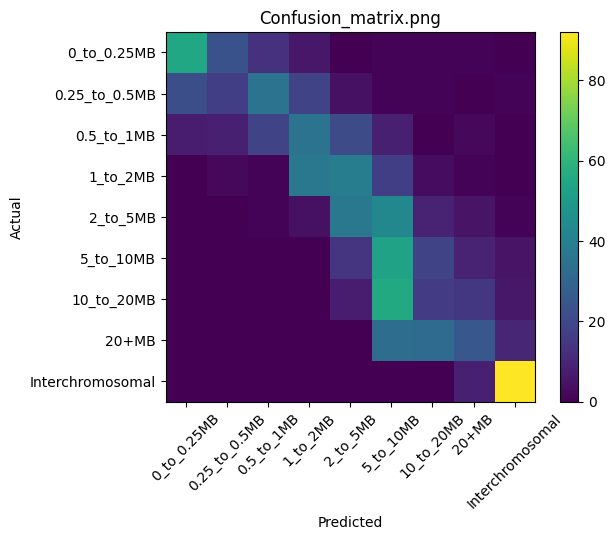

In [ ]:
evaluator.get_confusion_matrix(file_name = "Confusion_matrix.png")

<ipython-input-152-54bb0d9c292d>:41: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '55.00000000000001' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.pam.iloc[idx] = self.pam.iloc[idx]/self.counts[idx]*100
<ipython-input-152-54bb0d9c292d>:41: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '14.000000000000002' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.pam.iloc[idx] = self.pam.iloc[idx]/self.counts[idx]*100
<ipython-input-152-54bb0d9c292d>:41: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '56.00000000000001' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.pam.iloc[idx] = self.pam.iloc[idx]/self.counts[idx]*100


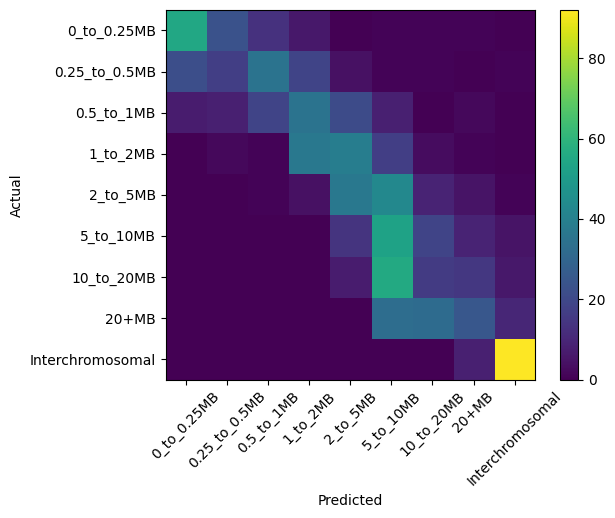

In [ ]:
evaluator.get_percents_of_actual_matrix()

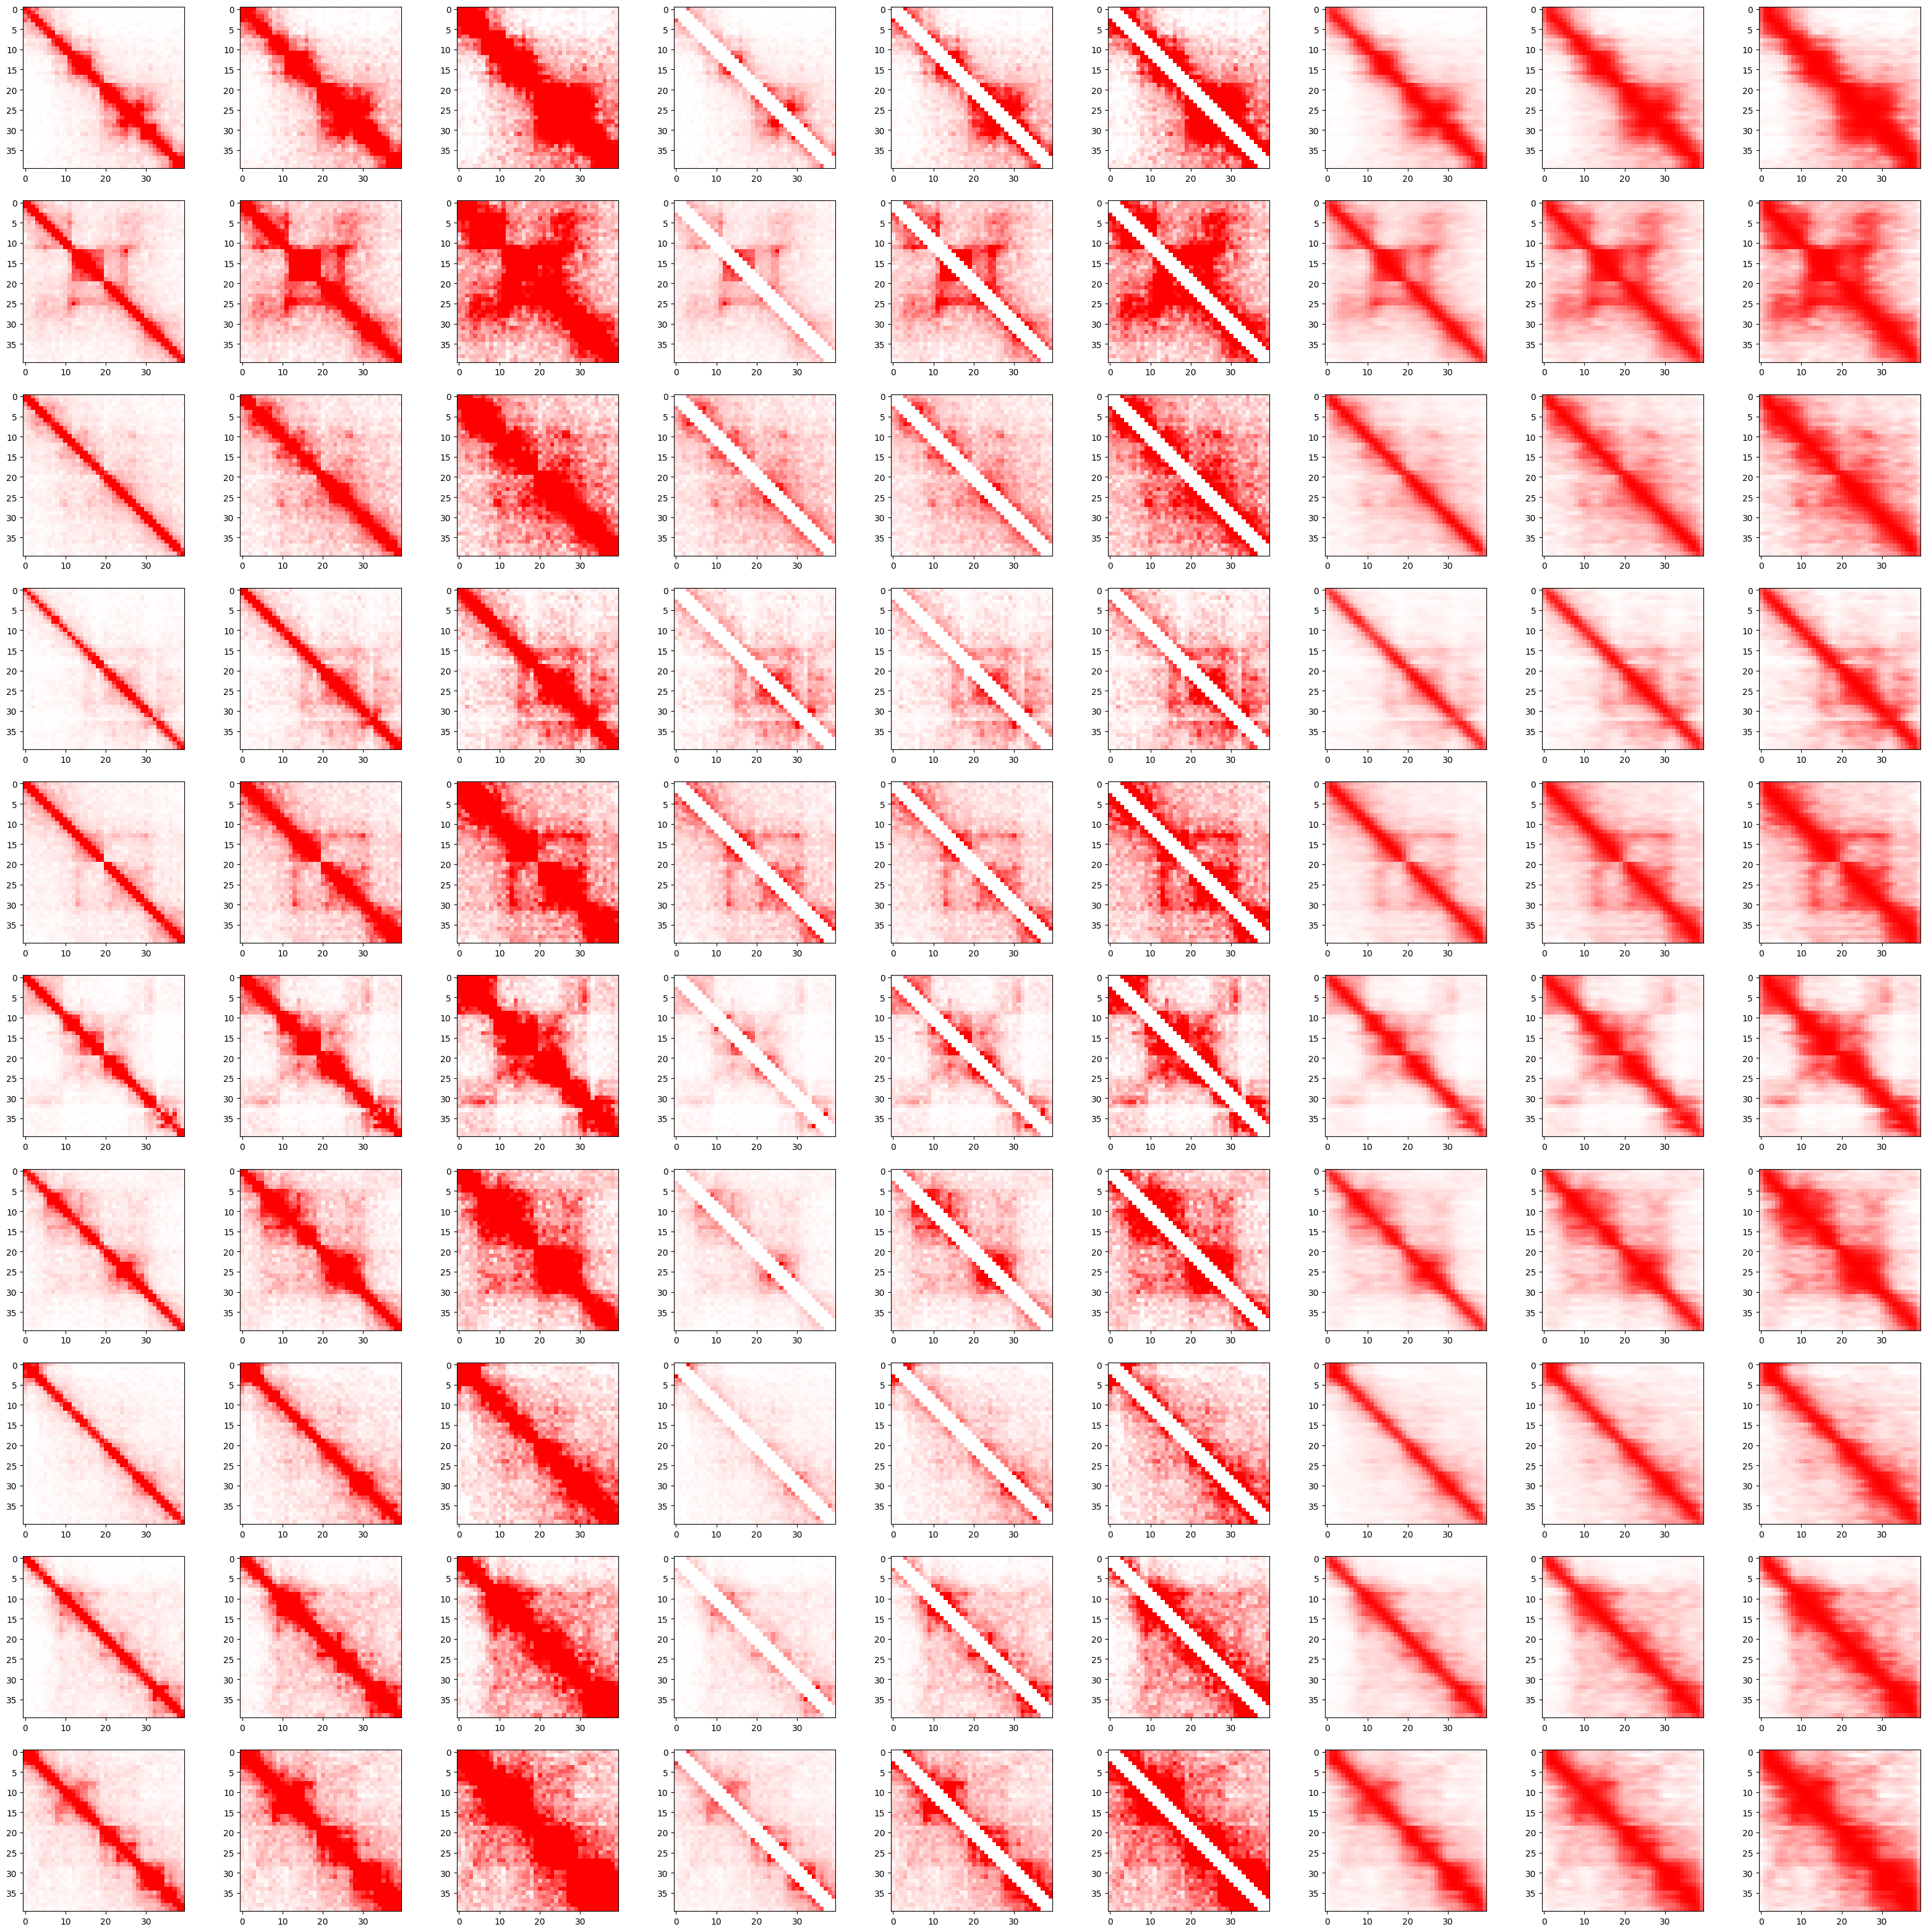

In [ ]:
evaluator.visualize_examples(predicted = 0, actual = 1)

In [ ]:
od.save("/content/drive/MyDrive/Chirag/Models/DistanceClassifier.h5")

Saliency maps

In [ ]:
!pip install saliency
import saliency
from tensorflow.keras import backend as K
from tensorflow.keras.activations import linear

In [ ]:
model = od

layer = model.layers[-1]  # For example, change the second layer

# Set the activation of the layer
layer.activation = linear

# Rebuild model (necessary because we've updated the activation function)
# You may need to save and load the model to properly rebuild it
model.save('temporary_model.h5')
model = tf.keras.models.load_model('temporary_model.h5')
# categorical_crossentropy for loss function
# Recompile the model if necessary
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

def get_saliency_map(model, image, class_idx):
    # Ensure the input image tensor has the correct shape

    with tf.GradientTape() as tape:
        # Add a batch dimension to the image tensor
        image_expanded = tf.expand_dims(image, axis=0)
        tape.watch(image_expanded)
        predictions = model(image_expanded)

        # Extract the probability of the target class from model predictions
        target_class_probs = predictions[:, class_idx]

    # Compute the gradients of the target class probability w.r.t. the input image
    gradient = tape.gradient(target_class_probs, image_expanded)

    # Squeeze the batch dimension from the gradient tensor
    saliency_map = tf.squeeze(gradient, axis=0)

    return saliency_map

In [ ]:
# Creating a dictionary with correctly predicted examples

correct_predictions_by_class = {class_label: [] for class_label in range(len(bins))}

# Populate the dictionary with correctly predicted examples
for i in range(len(evaluator.preds_max)):
    if evaluator.preds_max[i] == evaluator.testing_labels_max[i]:
        correct_predictions_by_class[evaluator.preds_max[i]].append(i)

# Print the results
for class_label, correct_examples in correct_predictions_by_class.items():
    print(f"Class {class_label}: {len(correct_examples)} correct predictions.")
    print(f"Examples: {correct_examples}")

Class 0: 55 correct predictions.
Examples: [1, 6, 8, 10, 13, 15, 16, 17, 19, 20, 22, 24, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 40, 44, 52, 53, 55, 58, 59, 60, 61, 62, 64, 66, 67, 68, 72, 75, 76, 77, 78, 80, 82, 83, 84, 85, 86, 87, 88, 89, 93, 94, 96, 98]
Class 1: 17 correct predictions.
Examples: [104, 118, 128, 138, 144, 151, 155, 164, 165, 166, 171, 177, 180, 191, 194, 198, 199]
Class 2: 19 correct predictions.
Examples: [200, 202, 210, 220, 222, 224, 234, 236, 237, 246, 252, 255, 257, 264, 266, 275, 286, 287, 289]
Class 3: 37 correct predictions.
Examples: [301, 306, 307, 313, 314, 315, 317, 320, 322, 323, 324, 327, 330, 338, 339, 341, 344, 346, 350, 351, 353, 355, 357, 359, 363, 368, 369, 375, 376, 379, 382, 385, 387, 391, 392, 397, 399]
Class 4: 37 correct predictions.
Examples: [402, 403, 409, 411, 412, 417, 418, 419, 421, 423, 424, 426, 428, 429, 432, 435, 438, 441, 452, 455, 462, 463, 464, 468, 474, 476, 477, 478, 479, 484, 487, 489, 490, 491, 495, 497, 498]
Class 5: 53 c

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


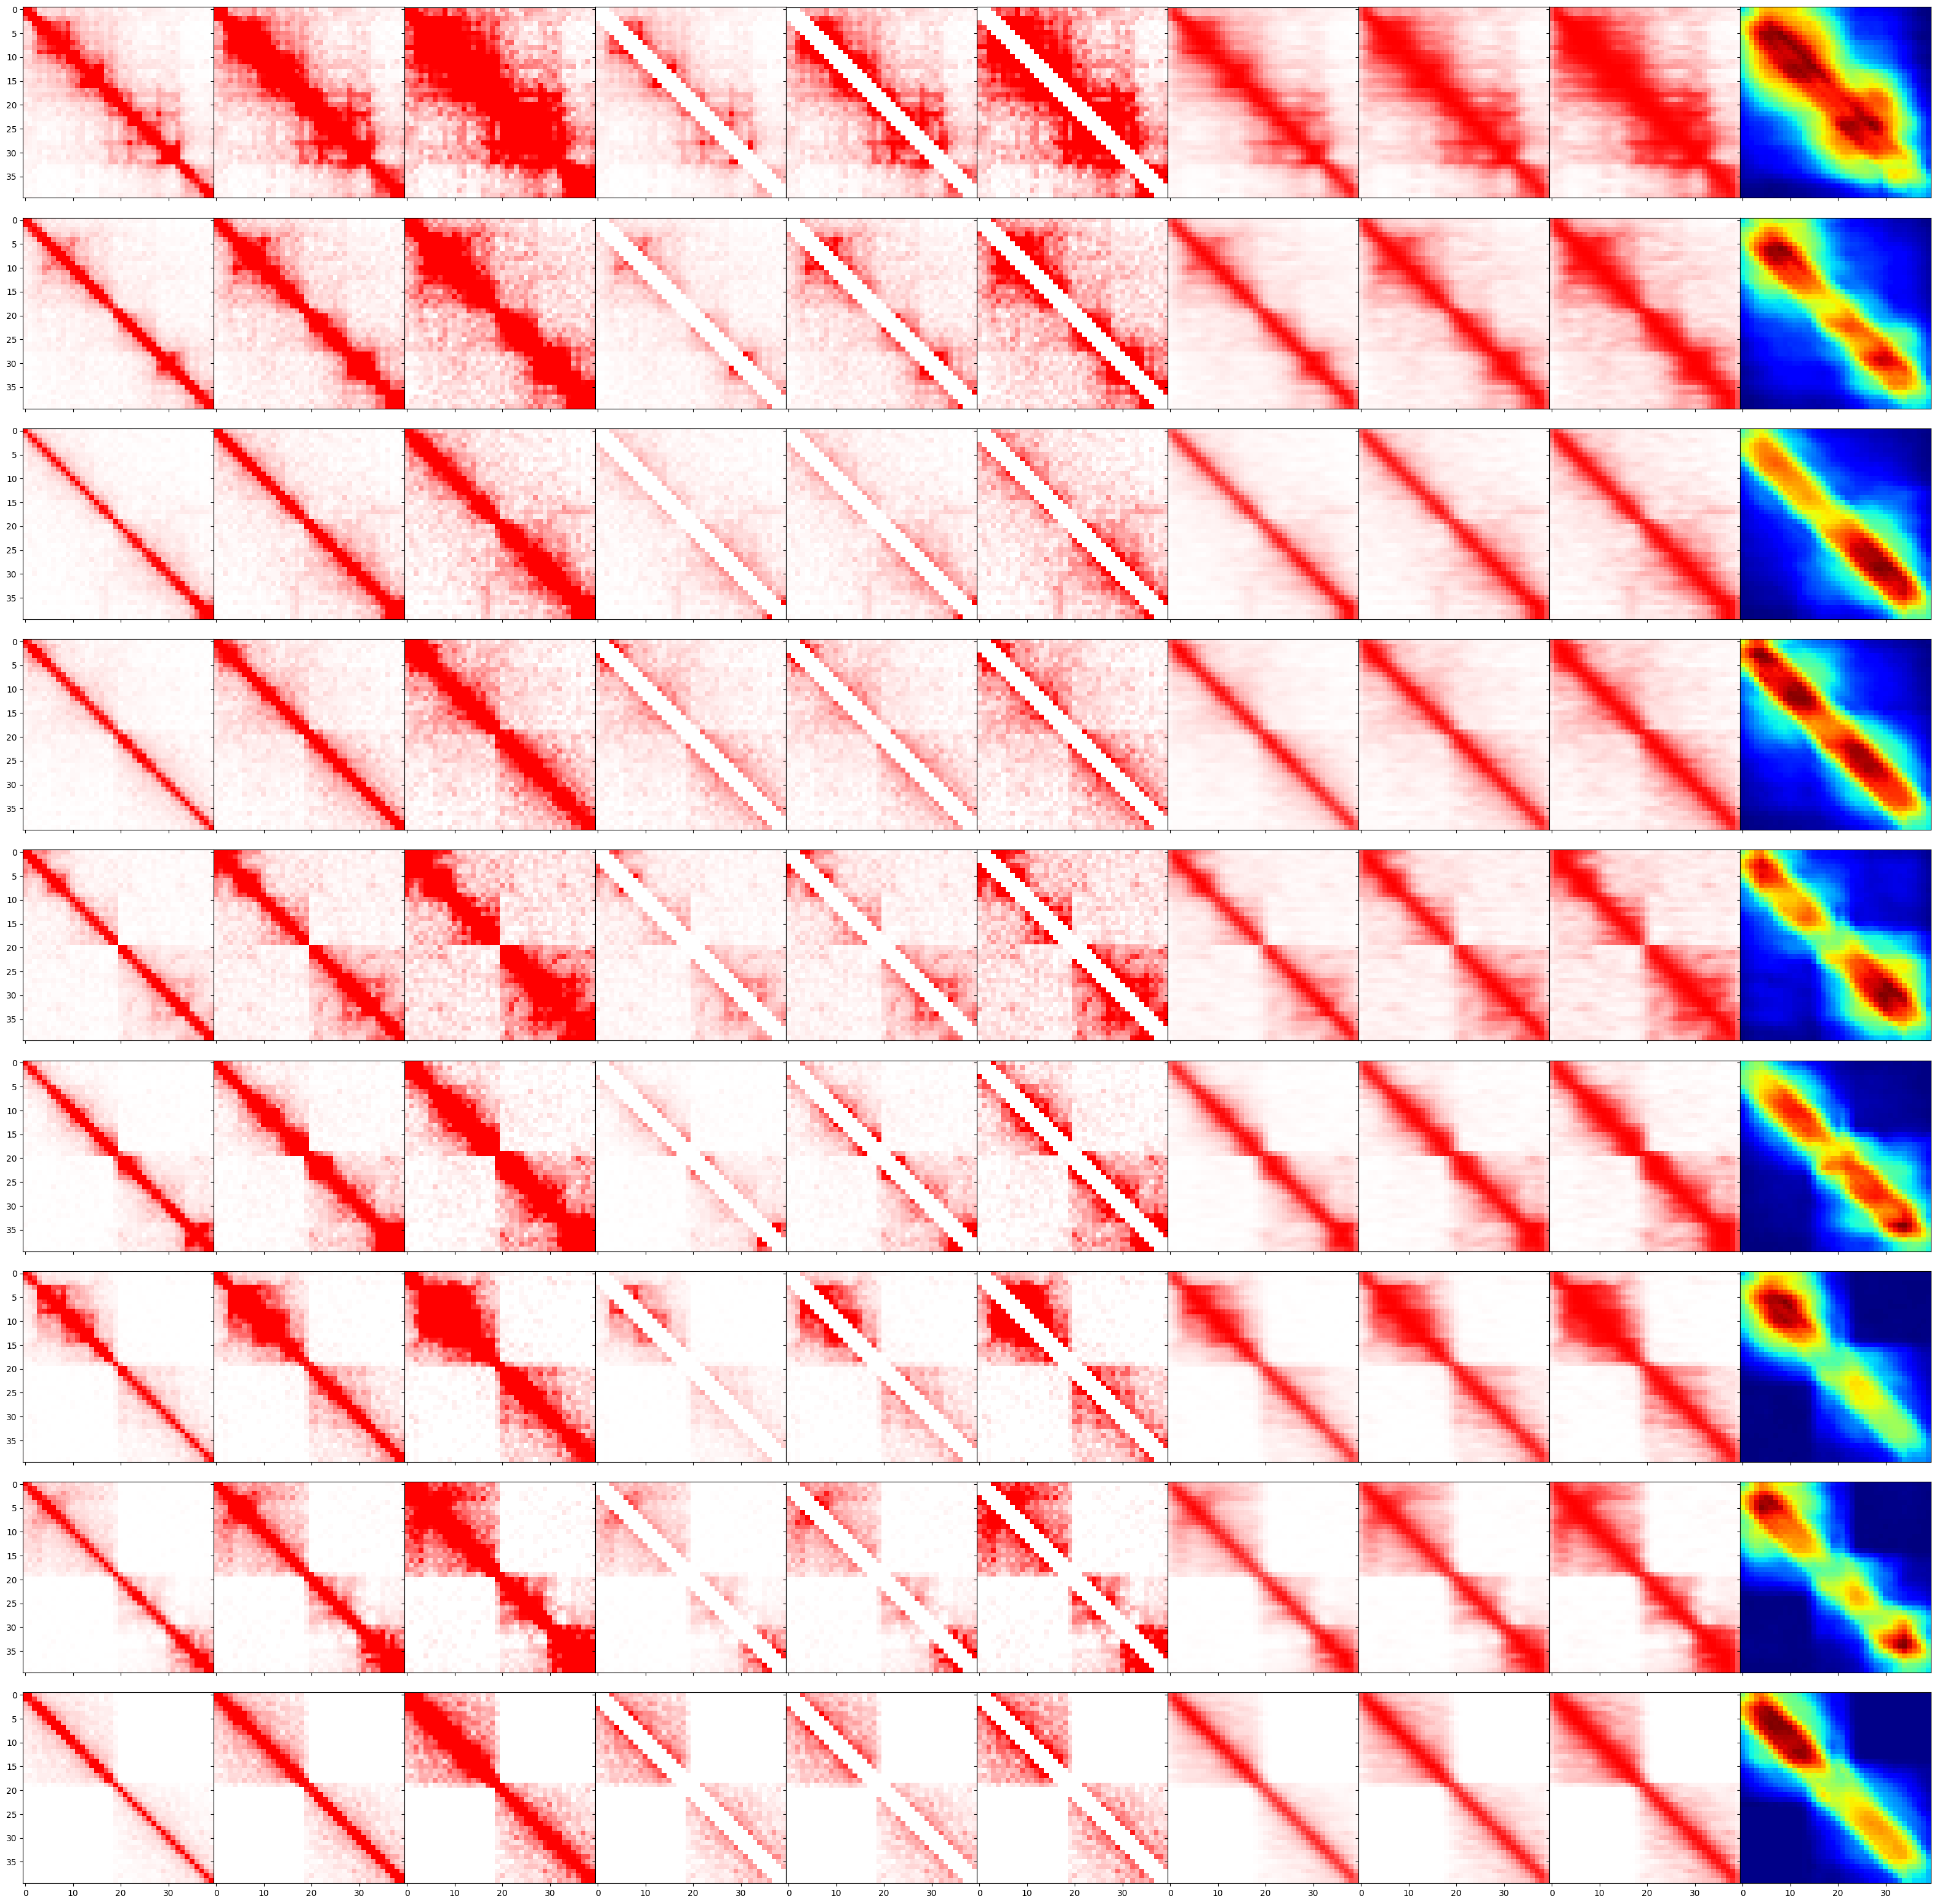

In [ ]:
# Plotting the activations of the first layer

fig, axs = plt.subplots(len(bins), testing_data.shape[-1]+1, figsize=(40, 40), sharex=True, sharey=True,
                        gridspec_kw={'hspace': 0, 'wspace': 0})

layer_name = model.layers[1].name
first_layer_activation_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

for bin in range(len(bins)):
  random_selection = random.sample(correct_predictions_by_class[bin], 1) # Choosing example where the model predicted correctly
  k = random_selection[0]
  activations = first_layer_activation_model.predict(testing_data[k:k+1]) # Extracting activations
  summed_array = np.sum(activations, axis=-1)
  for j in range(testing_data.shape[-1]):
    axs[bin, j].imshow(testing_data[k, :, :, j], cmap=br) # Plotting input
  axs[bin, j+1].imshow(summed_array[0, :, :], cmap='jet') # Plotting activations

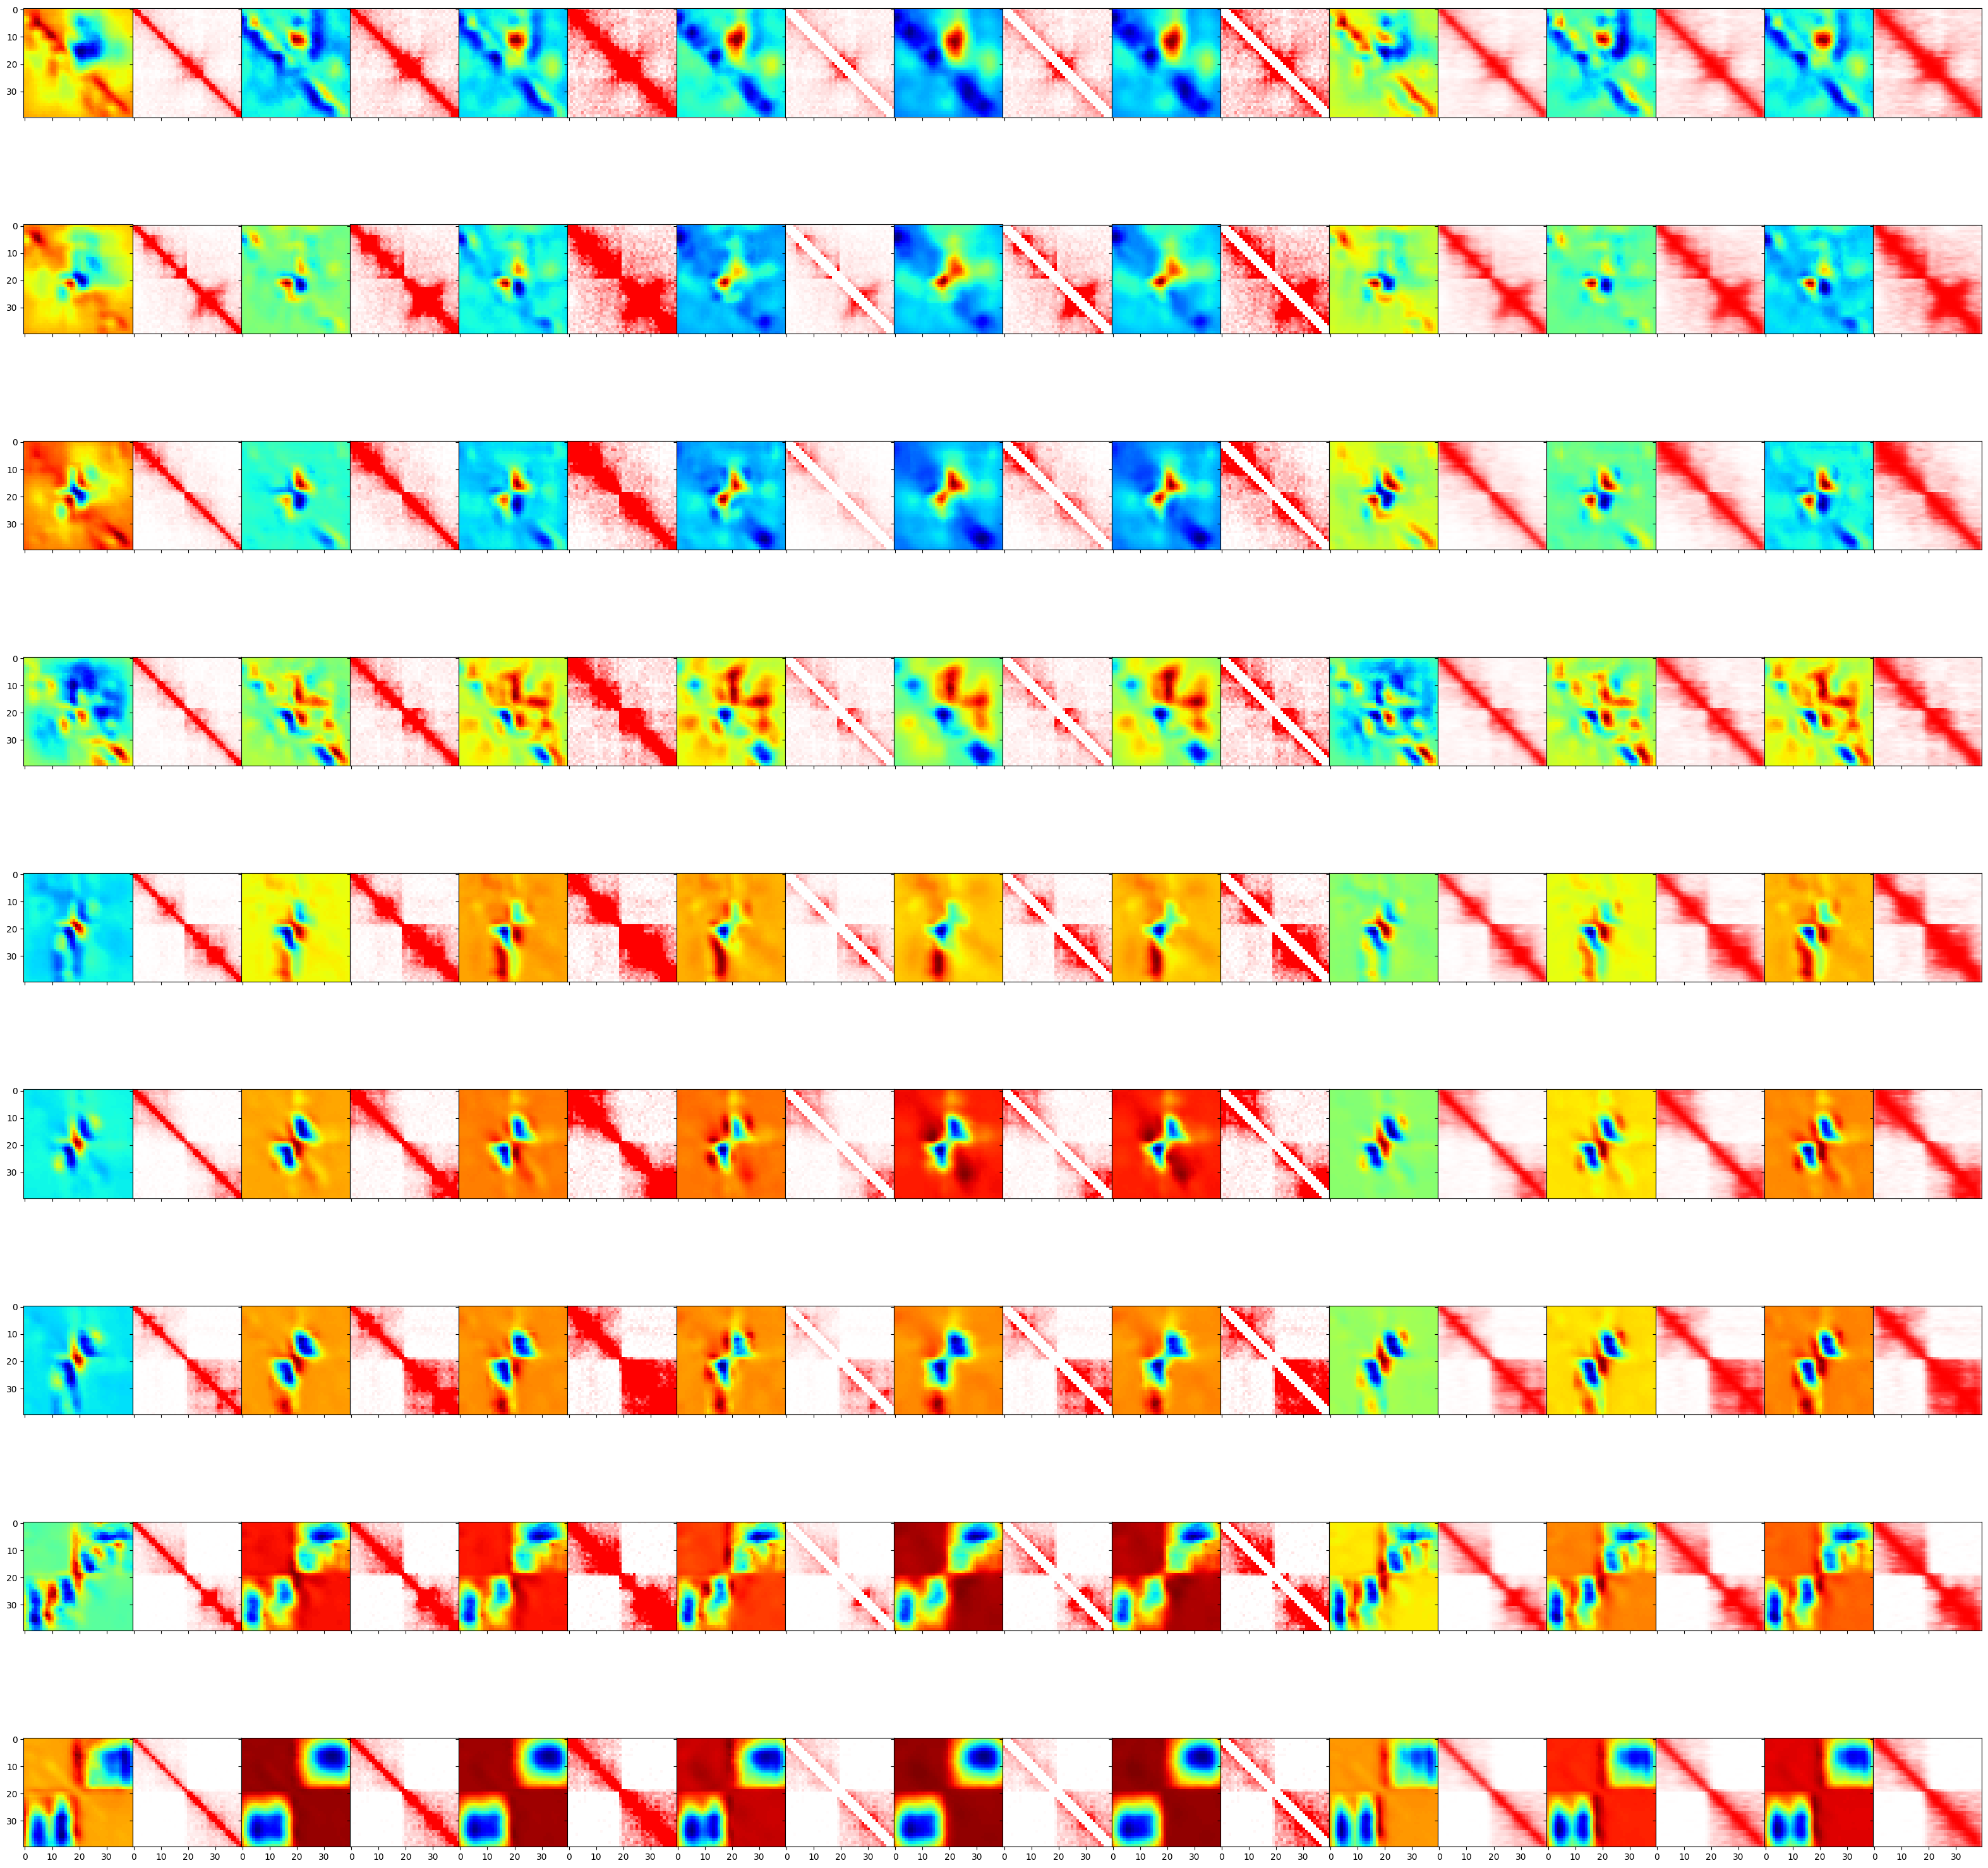

In [ ]:
# Plotting saliency maps for an example the model predicted correctly from each class

fig, axs = plt.subplots(len(bins), testing_data.shape[-1]*2, figsize=(40, 40), sharex=True, sharey=True,
                        gridspec_kw={'hspace': 0, 'wspace': 0})

for bin in range(len(bins)):
  k = random.sample(correct_predictions_by_class[bin], 1)[0] # Choosing example where the model predicted correctly
  saliency_map = get_saliency_map(model, testing_data[k], bin) # Getting saliency map
  for j in range(testing_data.shape[-1]):
    axs[bin, 2*j].imshow(saliency_map[:, :, j], cmap='jet') # Plotting saliency map
    axs[bin, 2*j+1].imshow(testing_data[k, :, :, j], cmap=br) # Plotting input

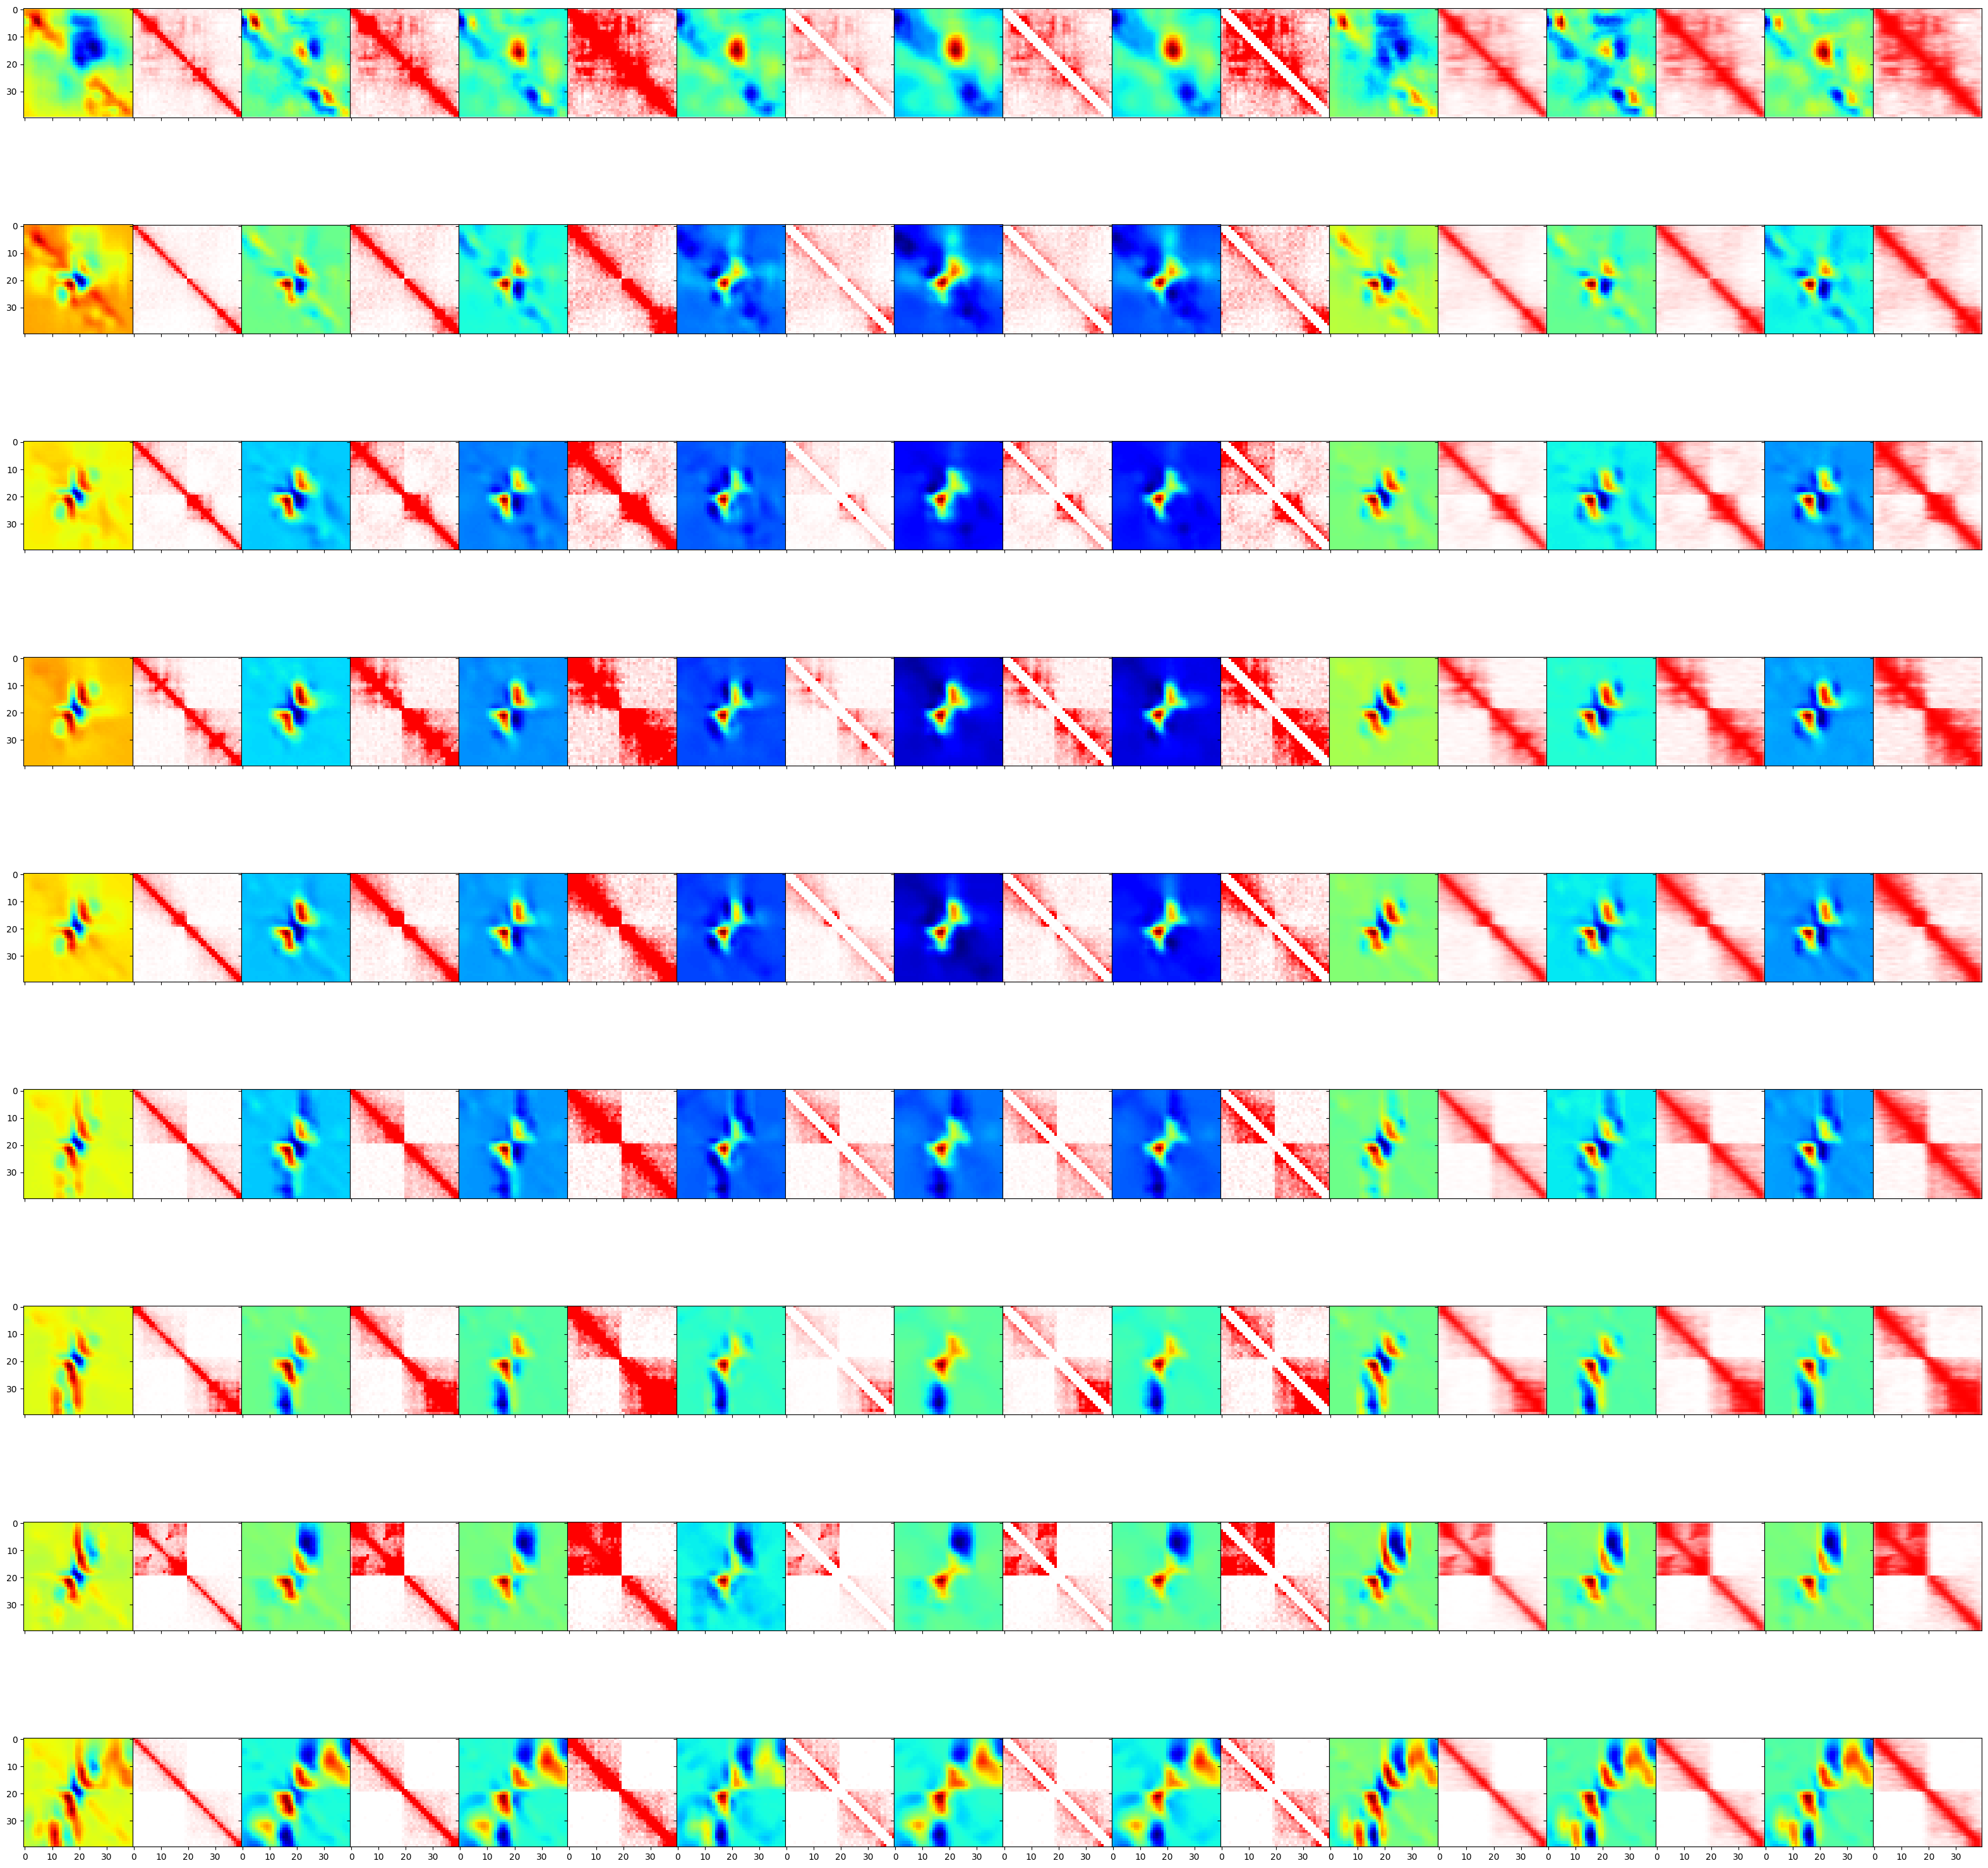

In [ ]:
# Plotting examples from all different classes and the corresponding saliency map of what the model sees for a particular bin in them

n = 100 # number of examples per class
bin = 0 # model predicts very first bin
fig, axs = plt.subplots(len(bins), training_data.shape[-1]*2, figsize=(40, 40), sharex=True, sharey=True,
                        gridspec_kw={'hspace': 0, 'wspace': 0})
for idx in range(len(bins)):
  k = random.sample(range(idx*n, idx*n+n), 1)[0]
  saliency_map = get_saliency_map(model, testing_data[k], bin)
  for j in range(training_data.shape[-1]):
    axs[idx, 2*j].imshow(saliency_map[:, :, j], cmap='jet') # Plotting saliency map
    axs[idx, 2*j+1].imshow(testing_data[k, :, :, j], cmap=br) # Plotting input

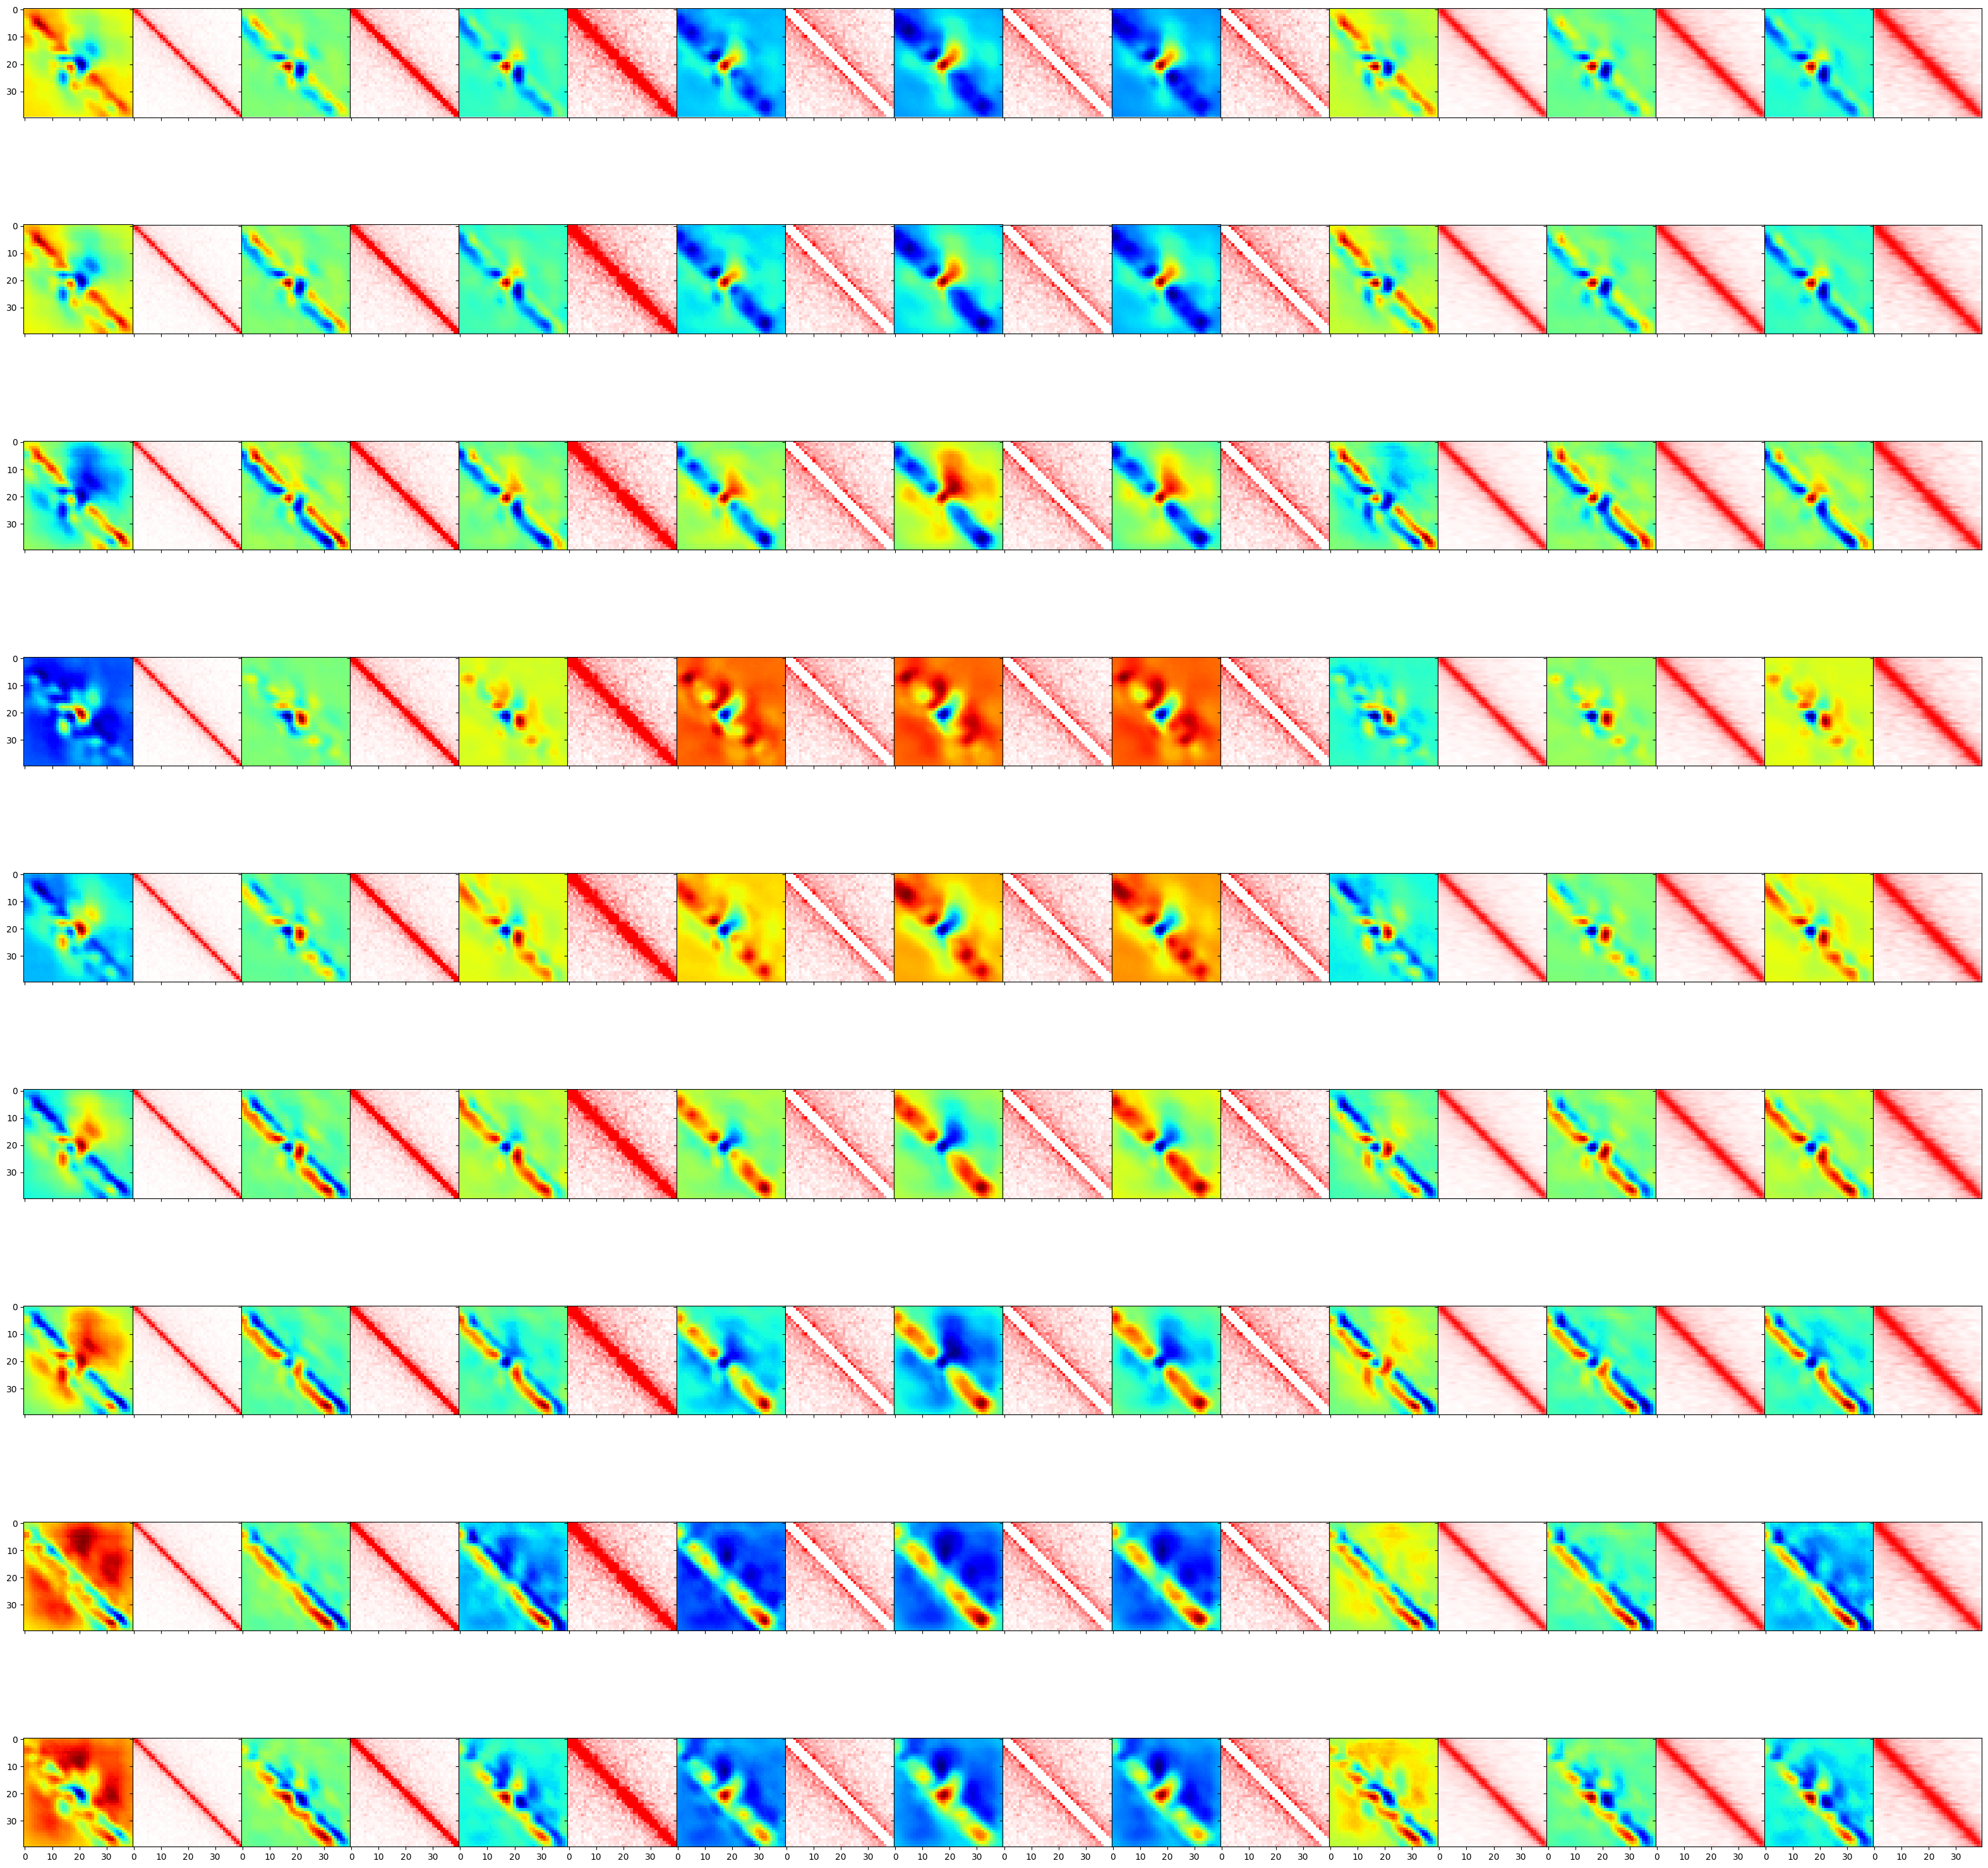

In [ ]:
# Plotting an example from a particular class and the corresponding saliency map of what the model sees for each bin in them

idx = 0 # actual class is first bin
fig, axs = plt.subplots(len(bins), training_data.shape[-1]*2, figsize=(40, 40), sharex=True, sharey=True,
                        gridspec_kw={'hspace': 0, 'wspace': 0})

k = random.sample(range(idx*n, idx*n+n), 1)[0]
for bin in range(len(bins)):
  saliency_map = get_saliency_map(model, testing_data[k], bin)
  for j in range(training_data.shape[-1]):
    axs[bin, 2*j].imshow(saliency_map[:, :, j], cmap='jet') # Plotting saliency map
    axs[bin, 2*j+1].imshow(testing_data[k, :, :, j], cmap=br) # Plotting input